In [ ]:
import sys
print(sys.executable)

/venv/main/bin/python


In [ ]:
# ============================================================
# EXPLORAÇÃO DO CORPUS brWaC
# ============================================================
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from datasets import load_dataset, Dataset
import re
from tqdm import tqdm
from transformers import AutoTokenizer
import re, random
import matplotlib.pyplot as plt
import numpy as np
from transformers import TrainerCallback

# ------------------------------------------------------------
# Carregar pequena amostra
# ------------------------------------------------------------
ds_raw = load_dataset("nlpufg/brwac", split="train")  # 10.000 linhas
#ds_raw = load_dataset("nlpufg/brwac", split="train")

# ============================================================
#  Limpeza textual básica
# ============================================================
print(f"Total de exemplos antes da limpeza: {len(ds_raw)}")

# salva um exemplo aleatório para comparar
idx = random.randint(0, len(ds_raw) - 1)
exemplo_original = ds_raw[idx]["text"]

def clean_text(text):
    """Limpa tags HTML, URLs, marcadores <END> e múltiplos espaços."""
    text = re.sub(r"<[^>]+>", " ", text)          # remove HTML
    text = re.sub(r"<END>", " ", text)            # remove marcadores
    text = re.sub(r"http\S+|www\S+", " ", text)   # remove URLs
    text = re.sub(r"\s+", " ", text).strip()      # normaliza espaços
    return text

# aplica limpeza
ds = ds_raw.map(lambda x: {"text": clean_text(x["text"])})
print("Limpeza básica concluída.")

# compara o mesmo exemplo antes e depois
print("\nExemplo antes da limpeza:")
print(exemplo_original[:300], "...\n")

print("Exemplo depois da limpeza:")
print(ds[idx]["text"][:300], "...")

# ============================================================
#  Filtro por tamanho de texto
# ============================================================
def filter_length(example):
    n_words = len(example["text"].split())
    return 10 < n_words < 1000   # mantém entre 10 e 1000 palavras

total_antes = len(ds)
ds = ds.filter(filter_length)
total_depois = len(ds)

print(f"\nFiltro de tamanho aplicado.")
print(f"Antes: {total_antes} exemplos | Depois: {total_depois} | Removidos: {total_antes - total_depois}")


ds = ds_raw


# ============================================================
# 0) Instalar dependências
# ============================================================
# !pip install -q transformers datasets accelerate


from datasets import load_dataset
from transformers import (
    AutoTokenizer, DataCollatorForLanguageModeling,
    AutoModelForMaskedLM, Trainer, TrainingArguments
)
import torch
import torch.nn.functional as F
from typing import Dict, Any, Tuple
import torch
from transformers import Trainer
from transformers.modeling_outputs import MaskedLMOutput


# ============================================================
#  Modelos e tokenizers
# ============================================================
teacher_name = "neuralmind/bert-base-portuguese-cased"
student_name = "prajjwal1/bert-tiny"

teacher = AutoModelForMaskedLM.from_pretrained(teacher_name)
student = AutoModelForMaskedLM.from_pretrained(student_name)

# Congelar o teacher
for p in teacher.parameters():
    p.requires_grad = False
teacher.eval()

# Tokenizers

#student_tok é o tokenizer do modelo (prajjwal1/bert-tiny).
student_tok = AutoTokenizer.from_pretrained(student_name)
teacher_tok = AutoTokenizer.from_pretrained(teacher_name)


max_len = 128

def tokenize_with_student(examples):
    return student_tok(
        examples["text"],
        truncation=True, padding="max_length", max_length=max_len
    )

tokenized = ds.map(tokenize_with_student, batched=True)
print(tokenized.column_names)   # deve conter 'text'

# ============================================================
# Collator com MLM -> Prepara os dados de entrada e saída para o treino do modelo Masked Language Modeling (MLM), mascarando 15% dos dados
# ============================================================
collator = DataCollatorForLanguageModeling(tokenizer=student_tok, mlm_probability=0.15)


# ============================================================
#  Funções auxiliares e loss combinada (documentadas e corrigidas)
# ============================================================

def mean_pool_last_hidden(hidden_states: torch.Tensor, attention_mask: torch.Tensor) -> torch.Tensor:
    """
    Faz o *mean pooling* (média ponderada) das representações da última camada do BERT.

    Cada sentença vira um único vetor, calculado pela média dos embeddings
    apenas dos tokens válidos (onde a máscara = 1), ignorando o padding.

    Parâmetros
    ----------
    hidden_states : torch.Tensor
        Tensor [batch_size, seq_len, hidden_dim] com as saídas da última camada oculta.
    attention_mask : torch.Tensor
        Tensor [batch_size, seq_len] com 1s para tokens válidos e 0s para padding.

    Retorna
    -------
    torch.Tensor
        Tensor [batch_size, hidden_dim] com uma representação média por sentença.
    """
    # Expande a máscara para coincidir com as dimensões dos hidden states
    mask = attention_mask.unsqueeze(-1).type_as(hidden_states)  # [B, L, 1]

    # Soma embeddings válidos (tokens onde mask=1)
    summed = (hidden_states * mask).sum(dim=1)                  # [B, H]

    # Conta tokens válidos e evita divisão por zero
    denom = mask.sum(dim=1).clamp(min=1e-6)                     # [B, 1]

    # Calcula média → vetor representando a sentença
    return summed / denom


def combined_loss(
    outputs_student,
    labels: torch.Tensor,
    text_batch: list[str],
    attention_mask_student: torch.Tensor
) -> tuple[torch.Tensor, dict]:
    """
    Calcula a loss combinada entre Student e Teacher.

    Combina duas perdas:
      1) MLM Loss — ensina o Student a prever tokens mascarados.
      2) Cosine Loss — faz o Student se aproximar semanticamente do Teacher,
         comparando as representações médias das sentenças.

    Parâmetros
    ----------
    outputs_student : ModelOutput
        Saída do modelo student (contém logits e hidden_states).
    labels : torch.Tensor
        Tokens-alvo para o Masked Language Modeling (-100 em tokens não mascarados).
    text_batch : list[str]
        Textos originais (não tokenizados) — usados pelo Teacher.
    attention_mask_student : torch.Tensor
        Máscara de atenção do batch do student (1 = token válido, 0 = padding).

    Retorna
    -------
    tuple(torch.Tensor, dict)
        - loss total (mlm_loss + 0.1 * cosine_loss)
        - dicionário com valores individuais de cada loss.
    """

    # ============================================================
    #  MLM Loss — Student aprende a prever tokens mascarados
    # ============================================================
    student_logits = outputs_student.logits  # [B, L, V_student]
    mlm_loss = F.cross_entropy(
        student_logits.view(-1, student_logits.size(-1)),
        labels.view(-1),
        ignore_index=-100  # ignora posições sem máscara
    )

    # ============================================================
    #  Cosine Loss — Student imita representações do Teacher
    # ============================================================
    with torch.no_grad():
        # Tokeniza os textos originais com o tokenizer do Teacher
        teacher_batch = teacher_tok(
            text_batch,
            truncation=True, padding="max_length",
            max_length=student_logits.size(1),
            return_tensors="pt"
        )

        # Garante que teacher e batch estejam no mesmo device do student
        device = student_logits.device
        teacher.to(device)
        teacher_batch = {k: v.to(device) for k, v in teacher_batch.items()}

        # Forward no Teacher (sem gradientes)
        outputs_teacher = teacher(**teacher_batch, output_hidden_states=True)

    # Extração das últimas camadas (representações ocultas)
    student_last = outputs_student.hidden_states[-1]             # [B, L, Hs]
    teacher_last = outputs_teacher.hidden_states[-1]             # [B, L, Ht]

    # Mean-pooling → 1 vetor por sentença
    student_sent = mean_pool_last_hidden(student_last, attention_mask_student)           # [B, Hs]
    teacher_sent = mean_pool_last_hidden(teacher_last, teacher_batch["attention_mask"])  # [B, Ht]

    # Ajuste de dimensão — corta para o menor tamanho entre student e teacher
    min_dim = min(student_sent.size(-1), teacher_sent.size(-1))
    student_vec = student_sent[..., :min_dim]
    teacher_vec = teacher_sent[..., :min_dim]

    # Similaridade de cosseno — mede o quão próximos são os embeddings
    cosine_loss = 1.0 - F.cosine_similarity(student_vec, teacher_vec, dim=-1).mean()

    # ============================================================
    # Loss final — combinação ponderada
    # ============================================================
    loss = mlm_loss + 0.1 * cosine_loss

    return loss, {
        "mlm_loss": mlm_loss.detach(),
        "cosine_loss": cosine_loss.detach()
    }



class DistillRepTrainer(Trainer):
    """
    Trainer customizado para distilação por representações (teacher -> student).

    Este Trainer substitui o `compute_loss` padrão para combinar:
      1) MLM loss do aluno (student) — aprendizado "normal" de BERT via máscara
      2) Cosine loss entre as representações de sentença do teacher e do student
         (mean-pool da última camada), que guia o student a "parecer" semânticamente
         com o teacher em português.

    Pré-requisitos importantes:
      - Passe `remove_unused_columns=False` em `TrainingArguments` para preservar
        a coluna `text` no batch.
      - Use um data collator que mantenha o campo `text`, como `KeepTextCollator`,
        pois o teacher precisa do texto cru para tokenizar com seu próprio tokenizer.

    Observações:
      - A KL nos logits NÃO é usada aqui porque os vocabulários de student e teacher
        são diferentes; por isso distilamos no nível de representação de sentença.
      - O peso da cosine loss está na função `combined_loss` (0.1 por padrão).
    """

    def compute_loss(
        self,
        model: torch.nn.Module,
        inputs: Dict[str, Any],
        return_outputs: bool = False,
        **kwargs: Any
    ) -> Tuple[torch.Tensor, MaskedLMOutput] | torch.Tensor:
        """
        Calcula a loss do batch corrente.

        Parâmetros
        ----------
        model : torch.nn.Module
            O modelo student (AutoModelForMaskedLM) a ser treinado.
        inputs : Dict[str, Any]
            Batch produzido pelo DataLoader/Collator contendo:
              - 'input_ids'           (LongTensor)  [B, L]   -> ids tokenizados pelo tokenizer do student
              - 'attention_mask'      (LongTensor)  [B, L]
              - 'labels'              (LongTensor)  [B, L]   -> rótulos MLM com -100 nas posições não mascaradas
              - 'text'                (List[str])   [B]      -> texto cru para o teacher tokenizar por conta própria
            *A chave 'text' só estará presente se:
              (i) o dataset mantiver a coluna 'text'
              (ii) TrainingArguments.remove_unused_columns == False
              (iii) o data collator não a descartar (ex.: KeepTextCollator).
        return_outputs : bool, opcional
            Se True, retorna (loss, outputs_student). Caso contrário, retorna apenas a loss.
        **kwargs : Any
            Argumentos adicionais que o Trainer pode enviar (ex.: num_items_in_batch).
            Mantidos para compatibilidade com versões recentes do `transformers`.

        Retorno
        -------
        torch.Tensor | (torch.Tensor, MaskedLMOutput)
            A loss escalar; opcionalmente, também os outputs do student.
        """

        # Extrai labels (para MLM) e o texto cru (para o teacher)
        labels = inputs.get("labels")
        text_batch = inputs.get("text")  # List[str]; esperado pelo combined_loss

        # Forward do student: pedimos hidden states para calcular a cosine loss depois

        outputs_student = model(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            labels=labels,
            output_hidden_states=True
        )

        # Combina MLM loss (student) + cosine loss (teacher vs student em nível de sentença)
        # Atenção: combined_loss chama o teacher internamente e faz a mean-pooling mask-aware
        loss, logs = combined_loss(
            outputs_student=outputs_student,
            labels=labels,
            text_batch=text_batch,
            attention_mask_student=inputs["attention_mask"]
        )

        # Log de métricas úteis para monitorar o treino
        # (usar .item() para evitar manter grafo no logger)
        self.log({
            "train_mlm_loss": logs["mlm_loss"].item(),
            "train_cosine_loss": logs["cosine_loss"].item()
        })

        # Compatibilidade com a API do Trainer
        return (loss, outputs_student) if return_outputs else loss

# ============================================================
class KeepTextCollator:
    def __init__(self, base_collator):
        self.base_collator = base_collator
    def __call__(self, features):
        texts = [f["text"] for f in features]
        feats_wo_text = [{k: v for k, v in f.items() if k != "text"} for f in features]
        batch = self.base_collator(feats_wo_text)
        batch["text"] = texts
        return batch

keep_text_collator = KeepTextCollator(collator)

# ============================================================
#  Divisão treino / teste
# ============================================================
from datasets import DatasetDict

# Exemplo: 90% treino, 10% teste
ds_split = ds.train_test_split(test_size=0.1, seed=42)
ds_train = ds_split["train"]
ds_test = ds_split["test"]

print(f"Dataset dividido → treino: {len(ds_train)} | teste: {len(ds_test)}")

# ============================================================

#  Tokenização com tokenizer do student
# ============================================================
tokenized_train = ds_train.map(tokenize_with_student, batched=True)
tokenized_test = ds_test.map(tokenize_with_student, batched=True)
print(f"Tokenização concluída. Colunas: {tokenized_train.column_names}")


from transformers import TrainingArguments

args = TrainingArguments(
    output_dir="./bert_tiny_pt_rep_distill",
    overwrite_output_dir=True,
    num_train_epochs=3,            # número de épocas
    per_device_train_batch_size=8,
    learning_rate=5e-5,
    logging_steps=999999,
    save_total_limit=1,
    fp16=True,
    report_to="none",
    remove_unused_columns=False
)
from transformers import TrainerCallback

class EpochLogger(TrainerCallback):
    def on_epoch_end(self, args, state, control, **kwargs):
        # imprime apenas no fim de cada época
        if state.log_history and "loss" in state.log_history[-1]:
            print(f"Época {int(state.epoch)} finalizada | Loss média: {state.log_history[-1]['loss']:.4f}")
# ============================================================
#  Treinamento
# ============================================================
trainer = DistillRepTrainer(
    model=student,
    args=args,
    train_dataset=tokenized_train,
    data_collator=keep_text_collator,
    tokenizer=student_tok,
    callbacks=[EpochLogger()]
)


print("Iniciando treinamento do BERT-tiny-PT...\n")
trainer.train()

print("\nTreinamento concluído.")
#trainer.save_model("./bert_tiny_pt_final")
#student_tok.save_pretrained("./bert_tiny_pt_final")

save_dir = "./bert_tiny_pt_final_v4"  # mesma pasta que você usa no load

# Salva o modelo treinado
trainer.save_model(save_dir)

# Salva o tokenizer usado no treino
student_tok.save_pretrained(save_dir)



Total de exemplos antes da limpeza: 3530808
Limpeza básica concluída.

Exemplo antes da limpeza:
COMECE A OPERAR NA BOLSA COM ROBÔS INVESTIDORES <END> Curso por Email para Automatizar seus Investimentos <END> Basta preencher o formulário abaixo para receber o curso em seu e-mail. <END> Quero receber <END> Quer operar com robôs na Bolsa de Valores com uma estratégia de sucesso? <END> Tudo sobre  ...

Exemplo depois da limpeza:
COMECE A OPERAR NA BOLSA COM ROBÔS INVESTIDORES Curso por Email para Automatizar seus Investimentos Basta preencher o formulário abaixo para receber o curso em seu e-mail. Quero receber Quer operar com robôs na Bolsa de Valores com uma estratégia de sucesso? Tudo sobre Robôs Investidores, do seu fun ...

Filtro de tamanho aplicado.
Antes: 3530808 exemplos | Depois: 3254222 | Removidos: 276586


Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


['text', 'input_ids', 'token_type_ids', 'attention_mask']
Dataset dividido → treino: 3177727 | teste: 353081


Map:   0%|          | 0/3177727 [00:00<?, ? examples/s]

Tokenização concluída. Colunas: ['text', 'input_ids', 'token_type_ids', 'attention_mask']


/tmp/ipykernel_16640/774059743.py:400: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `DistillRepTrainer.__init__`. Use `processing_class` instead.
  trainer = DistillRepTrainer(


Iniciando treinamento do BERT-tiny-PT...



/venv/main/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss


/venv/main/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/venv/main/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/venv/main/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/venv/main/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/venv/main/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked t


Treinamento concluído.


('./bert_tiny_pt_final_v4/tokenizer_config.json',
 './bert_tiny_pt_final_v4/special_tokens_map.json',
 './bert_tiny_pt_final_v4/vocab.txt',
 './bert_tiny_pt_final_v4/added_tokens.json',
 './bert_tiny_pt_final_v4/tokenizer.json')

In [ ]:
ds = ds_raw

## Não precisa executar

Média: 339.6
Máximo: 92296
1º quartil (Q1): 70.0
Mediana (Q2): 153.0
3º quartil (Q3): 303.0


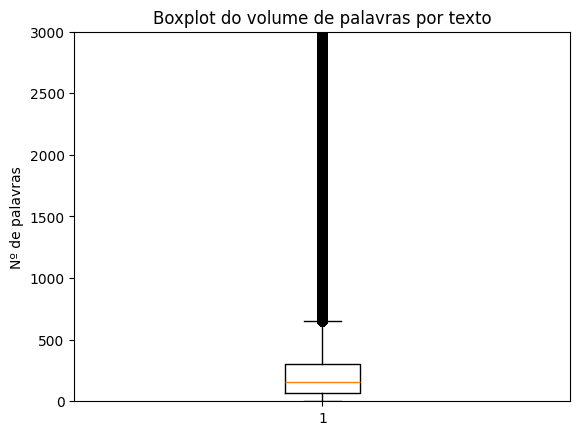

Média: 339.6 | Máximo: 92296


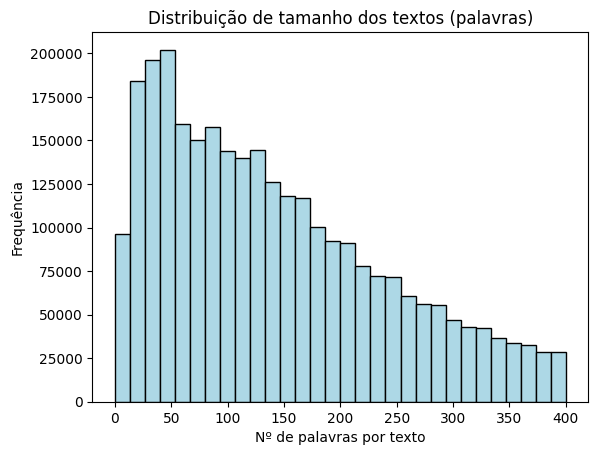

Dataset limpo salvo como 'brwac_cleaned.csv'


In [ ]:
lengths = [len(x.split()) for x in ds["text"]]

# Estatísticas principais
media = np.mean(lengths)
maximo = np.max(lengths)
q1, mediana, q3 = np.percentile(lengths, [25, 50, 75])

print(f"Média: {media:.1f}")
print(f"Máximo: {maximo}")
print(f"1º quartil (Q1): {q1:.1f}")
print(f"Mediana (Q2): {mediana:.1f}")
print(f"3º quartil (Q3): {q3:.1f}")

# Boxplot
plt.boxplot(lengths)
plt.title("Boxplot do volume de palavras por texto")
plt.ylabel("Nº de palavras")
plt.ylim(0, 3000)
plt.show()



# ------------------------------------------------------------
#  Medir comprimento dos textos (em palavras)
# ------------------------------------------------------------
import matplotlib.pyplot as plt
lengths = [len(x.split()) for x in ds["text"]]
print(f"Média: {sum(lengths)/len(lengths):.1f} | Máximo: {max(lengths)}")

plt.hist([l for l in lengths if l <= 400], bins=30, color='lightblue', edgecolor='black')
plt.title("Distribuição de tamanho dos textos (palavras)")
plt.xlabel("Nº de palavras por texto"); plt.ylabel("Frequência")
plt.show()


# Convert the cleaned dataset to a pandas DataFrame
df_cleaned = pd.DataFrame(ds)

# Save the DataFrame to a CSV file
output_filename = "brwac_cleaned.csv"
df_cleaned.to_csv(output_filename, index=False)

print(f"Dataset limpo salvo como '{output_filename}'")

# Avaliação

In [ ]:
from transformers import AutoModelForMaskedLM, AutoTokenizer
from torch.utils.data import DataLoader
import torch


def evaluate_mlm_loss(model, dataloader):
    """Calcula a loss média do modelo no conjunto de teste (MLM)."""
    model.eval()
    total_loss, total_tokens = 0, 0

    with torch.no_grad():
        for batch in dataloader:
            batch = {
                k: v.to(model.device) if isinstance(v, torch.Tensor) else v
                for k, v in batch.items()
            }
            outputs = model(
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                labels=batch["labels"]
            )
            mask = batch["labels"] != -100
            total_loss += outputs.loss.item() * mask.sum().item()
            total_tokens += mask.sum().item()

    return total_loss / total_tokens


device = "cuda" if torch.cuda.is_available() else "cpu"

# 1) Carrega o modelo tiny-PT salvo + tokenizer
student = AutoModelForMaskedLM.from_pretrained("./bert_tiny_pt_final_v4").to(device)
student_tok = AutoTokenizer.from_pretrained("./bert_tiny_pt_final_v4")

# 2) Usa o MESMO tokenized_test e collator que você já tinha
test_loader = DataLoader(tokenized_test, batch_size=8, collate_fn=keep_text_collator)

# 3) Avalia
print("\nAvaliando modelo distilado (português)...")
student.eval()
loss_pt = evaluate_mlm_loss(student, test_loader)
print(f"BERT-tiny-PT (distilado): MLM loss média = {loss_pt:.4f}")


print("\nAvaliando modelo original (inglês)...")
tiny_orig = AutoModelForMaskedLM.from_pretrained("prajjwal1/bert-tiny").to(student.device)
loss_orig = evaluate_mlm_loss(tiny_orig, test_loader)
print(f"BERT-tiny original: MLM loss média = {loss_orig:.4f}")


from transformers import AutoTokenizer, AutoModelForMaskedLM, DataCollatorForLanguageModeling

print("\nAvaliando BERTimbau (professor)...")

tok_imbau = AutoTokenizer.from_pretrained("neuralmind/bert-base-portuguese-cased")

import re

def clean_for_imbau(text):
    # tira tags tipo <END>, <DOC>, HTML etc. pra não zoar o tokenizer
    text = re.sub(r"<[^>]+>", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text if text else "."

def tokenize_imbau(batch):
    textos = [clean_for_imbau(t) for t in batch["text"]]
    return tok_imbau(
        textos,
        truncation=True,
        padding="max_length",
        max_length=128
    )

# ds_test precisa existir e ter coluna "text"
test_imbau = ds_test.map(tokenize_imbau, batched=True)

mlm_collator = DataCollatorForLanguageModeling(
    tokenizer=tok_imbau,
    mlm_probability=0.15
)

from torch.utils.data import DataLoader

loader_imbau = DataLoader(
    test_imbau.remove_columns([c for c in test_imbau.column_names if c not in ["input_ids", "attention_mask"]]),
    batch_size=8,
    collate_fn=mlm_collator
)

bertimbau = AutoModelForMaskedLM.from_pretrained(
    "neuralmind/bert-base-portuguese-cased"
).to(student.device)

loss_imbau = evaluate_mlm_loss(bertimbau, loader_imbau)
print(f"BERTimbau-base: MLM loss média = {loss_imbau:.4f}")

print("\n====== Comparação Final ======")
print(f"BERT-tiny-PT (distilado): {loss_pt:.4f}")
print(f"BERT-tiny original      : {loss_orig:.4f}")
print(f"BERTimbau-base          : {loss_imbau:.4f}")
print(f"\nGanho tiny-PT vs tiny original: {loss_orig - loss_pt:.4f}")
print(f"Ganho tiny-PT vs BERTimbau   : {loss_imbau - loss_pt:.4f}")





Avaliando modelo distilado (português)...
BERT-tiny-PT (distilado): MLM loss média = 1.9433

Avaliando modelo original (inglês)...
BERT-tiny original: MLM loss média = 5.7462

Avaliando BERTimbau (professor)...


Map:   0%|          | 0/353081 [00:00<?, ? examples/s]

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERTimbau-base: MLM loss média = 1.7569

====== Comparação Final ======
BERT-tiny-PT (distilado): 1.9433
BERT-tiny original      : 5.7462
BERTimbau-base          : 1.7569

Ganho tiny-PT vs tiny original: 3.8030
Ganho tiny-PT vs BERTimbau   : -0.1863


# Avaliação na base do Twitter

In [ ]:
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

# ============================================================
#  Carrega dataset TweetSentBR Few-shot (~2.000 exemplos)
# ============================================================
tweet = load_dataset("eduagarcia/tweetsentbr_fewshot")
tweet = tweet["train"].train_test_split(test_size=0.2, seed=42)
train_ds, test_ds = tweet["train"], tweet["test"]

print(f"Tamanho do dataset → treino: {len(train_ds)} | teste: {len(test_ds)}")
print(train_ds[0])

# ============================================================
#  Tokenização
# ============================================================
model_path_pt = "bert_tiny_pt_final_v4"
tok_pt = AutoTokenizer.from_pretrained(model_path_pt, local_files_only=True)
tok_en = AutoTokenizer.from_pretrained("prajjwal1/bert-tiny")

def tokenize_fn(batch, tokenizer):
    return tokenizer(
        batch["sentence"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

train_tok_pt = train_ds.map(lambda x: tokenize_fn(x, tok_pt), batched=True)
test_tok_pt  = test_ds.map(lambda x: tokenize_fn(x, tok_pt), batched=True)
test_tok_en  = test_ds.map(lambda x: tokenize_fn(x, tok_en), batched=True)

# ============================================================
#  Normaliza labels (Positive/Negative/Neutral → 0,1,2)
# ============================================================
label2id = {"Negative": 0, "Neutral": 1, "Positive": 2}

def encode_labels(example):
    return {"labels": label2id[example["label"]]}

train_tok_pt = train_tok_pt.map(encode_labels)
test_tok_pt  = test_tok_pt.map(encode_labels)
test_tok_en  = test_tok_en.map(encode_labels)

# Remove colunas não usadas (como 'label', 'id', 'sentence')
cols_to_remove = [c for c in train_tok_pt.column_names if c not in ['input_ids', 'attention_mask', 'labels']]
train_tok_pt = train_tok_pt.remove_columns(cols_to_remove)
test_tok_pt  = test_tok_pt.remove_columns(cols_to_remove)
test_tok_en  = test_tok_en.remove_columns(cols_to_remove)

# ============================================================
# Métricas
# ============================================================
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="macro")
    return {"accuracy": acc, "f1": f1}


# ============================================================
#  Avaliação do BERT-tiny-PT
# ============================================================
model_pt = AutoModelForSequenceClassification.from_pretrained(
    model_path_pt, num_labels=3, local_files_only=True
)
args_pt = TrainingArguments(
    output_dir="./eval_pt",
    per_device_eval_batch_size=16,
    report_to="none"
)

trainer_pt = Trainer(
    model=model_pt,
    args=args_pt,
    eval_dataset=test_tok_pt,
    tokenizer=tok_pt,
    compute_metrics=compute_metrics,
    data_collator=DataCollatorWithPadding(tokenizer=tok_pt)
)

metrics_pt = trainer_pt.evaluate()
print("\nBERT-tiny-PT (distilado):", metrics_pt)
# ============================================================
#  Avaliação do BERT-tiny original (inglês)
# ============================================================
model_en = AutoModelForSequenceClassification.from_pretrained(
    "prajjwal1/bert-tiny", num_labels=3
)
args_en = TrainingArguments(
    output_dir="./eval_en",
    per_device_eval_batch_size=16,
    report_to="none"
)

trainer_en = Trainer(
    model=model_en,
    args=args_en,
    eval_dataset=test_tok_en,
    tokenizer=tok_en,
    compute_metrics=compute_metrics,
    data_collator=DataCollatorWithPadding(tokenizer=tok_en)
)

metrics_en = trainer_en.evaluate()
print("\nBERT-tiny original:", metrics_en)


tok_imbau = AutoTokenizer.from_pretrained(
    "neuralmind/bert-base-portuguese-cased"
)

test_tok_imbau = test_ds.map(lambda x: tokenize_fn(x, tok_imbau), batched=True)
test_tok_imbau = test_tok_imbau.map(encode_labels)
test_tok_imbau = test_tok_imbau.remove_columns(cols_to_remove)


# ============================================================
#  Avaliação do BERTimbau (professor)
# ============================================================
model_imbau = AutoModelForSequenceClassification.from_pretrained(
    "neuralmind/bert-base-portuguese-cased",
    num_labels=3
)
args_imbau = TrainingArguments(
    output_dir="./eval_imbau",
    per_device_eval_batch_size=16,
    report_to="none"
)

trainer_imbau = Trainer(
    model=model_imbau,
    args=args_imbau,
    eval_dataset=test_tok_imbau,
    tokenizer=tok_imbau,
    compute_metrics=compute_metrics,
    data_collator=DataCollatorWithPadding(tokenizer=tok_imbau)
)

metrics_imbau = trainer_imbau.evaluate()
print("\nBERTimbau-base:", metrics_imbau)

print(f"\nF1 Tiny-PT      : {metrics_pt['eval_f1']:.4f}")
print(f"F1 Tiny original: {metrics_en['eval_f1']:.4f}")
print(f"F1 BERTimbau    : {metrics_imbau['eval_f1']:.4f}")

print(f"\nGanho Tiny-PT vs Tiny original (F1): {metrics_pt['eval_f1'] - metrics_en['eval_f1']:.4f}")
print(f"Ganho Tiny-PT vs BERTimbau (F1)    : {metrics_pt['eval_f1'] - metrics_imbau['eval_f1']:.4f}")



Tamanho do dataset → treino: 60 | teste: 15
{'id': 76, 'sentence': 'se o lindo USERNAME sair eu nem sei viu', 'label': 'Positive'}


Map:   0%|          | 0/60 [00:00<?, ? examples/s]

Map:   0%|          | 0/15 [00:00<?, ? examples/s]

Map:   0%|          | 0/60 [00:00<?, ? examples/s]

Map:   0%|          | 0/15 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert_tiny_pt_final_v4 and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_16640/2538033047.py:82: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_pt = Trainer(
/venv/main/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



BERT-tiny-PT (distilado): {'eval_loss': 1.0921000242233276, 'eval_accuracy': 0.4666666666666667, 'eval_f1': 0.21212121212121213, 'eval_runtime': 0.0526, 'eval_samples_per_second': 285.141, 'eval_steps_per_second': 19.009}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_16640/2538033047.py:105: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_en = Trainer(
/venv/main/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



BERT-tiny original: {'eval_loss': 1.0356254577636719, 'eval_accuracy': 0.4, 'eval_f1': 0.19047619047619047, 'eval_runtime': 0.0362, 'eval_samples_per_second': 414.815, 'eval_steps_per_second': 27.654}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_16640/2538033047.py:140: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_imbau = Trainer(
/venv/main/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



BERTimbau-base: {'eval_loss': 1.1011964082717896, 'eval_accuracy': 0.3333333333333333, 'eval_f1': 0.27777777777777773, 'eval_runtime': 0.0767, 'eval_samples_per_second': 195.567, 'eval_steps_per_second': 13.038}

F1 Tiny-PT      : 0.2121
F1 Tiny original: 0.1905
F1 BERTimbau    : 0.2778

Ganho Tiny-PT vs Tiny original (F1): 0.0216
Ganho Tiny-PT vs BERTimbau (F1)    : -0.0657


#### Visualizar a predição

In [ ]:
from transformers import pipeline

# Cria um pipeline de classificação de texto com o modelo treinado
sentiment_pt = pipeline(
    "text-classification",
    model=model_pt,
    tokenizer=tok_pt,
    return_all_scores=True  # mostra probabilidades das 3 classes
)

# Teste com frases novas
frases = [
    "Amei o atendimento, tudo perfeito!",
    "O produto chegou quebrado e ninguém resolveu.",
    "É um produto razoável, mas poderia ser melhor."
]

# Faz predição em cada frase
for frase in frases:
    resultado = sentiment_pt(frase)[0]
    print(f"\nFrase: {frase}")
    for classe in resultado:
        print(f"  {classe['label']}: {classe['score']:.3f}")


Device set to use cuda:0



Frase: Amei o atendimento, tudo perfeito!
  LABEL_0: 0.330
  LABEL_1: 0.330
  LABEL_2: 0.340

Frase: O produto chegou quebrado e ninguém resolveu.
  LABEL_0: 0.331
  LABEL_1: 0.331
  LABEL_2: 0.338

Frase: É um produto razoável, mas poderia ser melhor.
  LABEL_0: 0.323
  LABEL_1: 0.341
  LABEL_2: 0.336


/venv/main/lib/python3.12/site-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


# Avaliação Similaridade Textual (STS) do ASSIN2.

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset
from scipy.stats import pearsonr
import numpy as np

# ============================================================
# Carregar o dataset ASSIN2
# ============================================================
assin = load_dataset("assin2")
test_assin = assin["test"]   # usamos apenas o conjunto de teste

print("Exemplo:", test_assin[0])

device = "cuda" if torch.cuda.is_available() else "cpu"

# ============================================================
# Funções auxiliares
# ============================================================
def embed_sentence(model, tokenizer, sentence):
    """Gera embedding médio da frase usando o modelo BERT."""
    enc = tokenizer(
        sentence,
        return_tensors="pt",
        truncation=True,
        padding="max_length",
        max_length=128
    ).to(model.device)

    with torch.no_grad():
        out = model(**enc)

    # mean pooling da última camada
    emb = out.last_hidden_state.mean(dim=1)
    return emb.squeeze()

def evaluate_sts(model, tokenizer, dataset):
    """Avalia similaridade no ASSIN2 usando Pearson."""
    preds = []
    gold = []

    for item in dataset:
        # ASSIN2 usa "premise" e "hypothesis"
        s1 = item["premise"]
        s2 = item["hypothesis"]

        emb1 = embed_sentence(model, tokenizer, s1)
        emb2 = embed_sentence(model, tokenizer, s2)

        # Similaridade de cosseno
        sim = torch.nn.functional.cosine_similarity(emb1, emb2, dim=0).item()

        preds.append(sim)
        gold.append(item["relatedness_score"])

    pearson = pearsonr(preds, gold)[0]
    return pearson

# ============================================================
# 1) BERT-tiny-PT (seu modelo distilado em PT)
# ============================================================
model_path_pt = "./bert_tiny_pt_final_v4"  # usa o caminho final que tá OK aí no notebook

tok_pt = AutoTokenizer.from_pretrained(model_path_pt)
model_pt = AutoModel.from_pretrained(model_path_pt).to(device)

pearson_pt = evaluate_sts(model_pt, tok_pt, test_assin)
print(f"\nBERT-tiny-PT (distilado) → Pearson = {pearson_pt:.4f}")

# ============================================================
# 2) BERT-tiny original (inglês)
# ============================================================
tok_en = AutoTokenizer.from_pretrained("prajjwal1/bert-tiny")
model_en = AutoModel.from_pretrained("prajjwal1/bert-tiny").to(device)

pearson_en = evaluate_sts(model_en, tok_en, test_assin)
print(f"BERT-tiny original (inglês) → Pearson = {pearson_en:.4f}")

# ============================================================
# 3) BERTimbau (professor em PT-BR)
# ============================================================
tok_imbau = AutoTokenizer.from_pretrained("neuralmind/bert-base-portuguese-cased")
model_imbau = AutoModel.from_pretrained("neuralmind/bert-base-portuguese-cased").to(device)

pearson_imbau = evaluate_sts(model_imbau, tok_imbau, test_assin)
print(f"BERTimbau-base → Pearson = {pearson_imbau:.4f}")

# ============================================================
# Comparação final
# ============================================================
print("\n=========== COMPARAÇÃO ASSIN2 (STS – Pearson) ===========")
print(f"BERTimbau-base          : {pearson_imbau:.4f}")
print(f"BERT-tiny-PT (distilado): {pearson_pt:.4f}")
print(f"BERT-tiny original      : {pearson_en:.4f}")
print("=========================================================")


Some weights of BertModel were not initialized from the model checkpoint at ./bert_tiny_pt_final_v4 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Exemplo: {'sentence_pair_id': 0, 'premise': 'O cachorro caramelo está assistindo um cachorro castanho que está nadando em uma lagoa', 'hypothesis': 'Um cachorro de estimação está de pé no banco e está olhando outro cachorro, que é castanho, na lagoa', 'relatedness_score': 3.799999952316284, 'entailment_judgment': 0}

BERT-tiny-PT (distilado) → Pearson = 0.5763
BERT-tiny original (inglês) → Pearson = 0.5262
BERTimbau-base → Pearson = 0.6139

=========== COMPARAÇÃO ASSIN2 (STS – Pearson) ===========
BERTimbau-base          : 0.6139
BERT-tiny-PT (distilado): 0.5763
BERT-tiny original      : 0.5262


# CLASSIFICAÇÃO: “IGUAL / CONTRA / NEUTRA” (RTE) no ASSIN2

In [ ]:
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

# ============================================================
#  Carregar ASSIN2 (tarefa RTE)
# ============================================================
assin = load_dataset("assin2")
train = assin["train"]
test  = assin["validation"]  # validação como teste

print("Exemplo treino:", train[0])

# Labels da tarefa
label2id = {
    "entailment": 0,
    "contradiction": 1,
    "neutral": 2
}
id2label = {v: k for k, v in label2id.items()}

def encode_labels(example):
    # aqui usamos o inteiro que já vem no dataset
    return {"labels": int(example["entailment_judgment"])}


def tokenize_batch(batch, tokenizer):
    # campos corretos: 'premise' e 'hypothesis'
    return tokenizer(
        batch["premise"],
        batch["hypothesis"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

# ============================================================
# Métricas
# ============================================================
def compute_metrics(pred):
    logits, labels = pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="macro")
    }

# ============================================================
# 1) BERTimbau (professor)
# ============================================================
tok_imbau = AutoTokenizer.from_pretrained("neuralmind/bert-base-portuguese-cased")

train_tok_imbau = train.map(lambda x: tokenize_batch(x, tok_imbau), batched=True)
test_tok_imbau  = test.map(lambda x: tokenize_batch(x, tok_imbau), batched=True)

train_tok_imbau = train_tok_imbau.map(encode_labels)
test_tok_imbau  = test_tok_imbau.map(encode_labels)

cols_remove = [c for c in train_tok_imbau.column_names
               if c not in ["input_ids", "attention_mask", "labels"]]

train_tok_imbau = train_tok_imbau.remove_columns(cols_remove)
test_tok_imbau  = test_tok_imbau.remove_columns(cols_remove)

model_imbau = AutoModelForSequenceClassification.from_pretrained(
    "neuralmind/bert-base-portuguese-cased",
    num_labels=3,
    id2label=id2label,
    label2id=label2id
)

args_imbau = TrainingArguments(
    output_dir="./eval_imbau_rte",
    per_device_eval_batch_size=16,
    report_to="none"
)

trainer_imbau = Trainer(
    model=model_imbau,
    args=args_imbau,
    eval_dataset=test_tok_imbau,
    compute_metrics=compute_metrics,
    data_collator=DataCollatorWithPadding(tokenizer=tok_imbau)
)

metrics_imbau = trainer_imbau.evaluate()
print("\nBERTimbau (Entailment):", metrics_imbau)

# ============================================================
# 2) BERT-tiny original (inglês)
# ============================================================
tok_tiny_en = AutoTokenizer.from_pretrained("prajjwal1/bert-tiny")

train_tok_en = train.map(lambda x: tokenize_batch(x, tok_tiny_en), batched=True)
test_tok_en  = test.map(lambda x: tokenize_batch(x, tok_tiny_en), batched=True)

train_tok_en = train_tok_en.map(encode_labels)
test_tok_en  = test_tok_en.map(encode_labels)

train_tok_en = train_tok_en.remove_columns(cols_remove)
test_tok_en  = test_tok_en.remove_columns(cols_remove)

model_tiny_en = AutoModelForSequenceClassification.from_pretrained(
    "prajjwal1/bert-tiny",
    num_labels=3,
    id2label=id2label,
    label2id=label2id
)

args_en = TrainingArguments(
    output_dir="./eval_tiny_en_rte",
    per_device_eval_batch_size=16,
    report_to="none"
)

trainer_en = Trainer(
    model=model_tiny_en,
    args=args_en,
    eval_dataset=test_tok_en,
    compute_metrics=compute_metrics,
    data_collator=DataCollatorWithPadding(tokenizer=tok_tiny_en)
)

metrics_tiny_en = trainer_en.evaluate()
print("\nBERT-tiny original (Entailment):", metrics_tiny_en)

# ============================================================
# 3) BERT-tiny-PT (seu modelo adaptado)
# ============================================================
tok_tiny_pt = AutoTokenizer.from_pretrained(
    "bert_tiny_pt_final_v4",  # usa a versão nova que está boa
)

train_tok_pt = train.map(lambda x: tokenize_batch(x, tok_tiny_pt), batched=True)
test_tok_pt  = test.map(lambda x: tokenize_batch(x, tok_tiny_pt), batched=True)

train_tok_pt = train_tok_pt.map(encode_labels)
test_tok_pt  = test_tok_pt.map(encode_labels)

train_tok_pt = train_tok_pt.remove_columns(cols_remove)
test_tok_pt  = test_tok_pt.remove_columns(cols_remove)

model_tiny_pt = AutoModelForSequenceClassification.from_pretrained(
    "bert_tiny_pt_final_v4",
    num_labels=3,
    id2label=id2label,
    label2id=label2id
)

args_pt = TrainingArguments(
    output_dir="./eval_tiny_pt_rte",
    per_device_eval_batch_size=16,
    report_to="none"
)

trainer_pt = Trainer(
    model=model_tiny_pt,
    args=args_pt,
    eval_dataset=test_tok_pt,
    compute_metrics=compute_metrics,
    data_collator=DataCollatorWithPadding(tokenizer=tok_tiny_pt)
)

metrics_tiny_pt = trainer_pt.evaluate()
print("\nBERT-tiny-PT (Entailment):", metrics_tiny_pt)

# ============================================================
#  Comparação final
# ============================================================
print("\n========== RESULTADOS ASSIN2 (Entailment) ==========")
print("BERTimbau-base     :", metrics_imbau)
print("BERT-tiny original :", metrics_tiny_en)
print("BERT-tiny-PT       :", metrics_tiny_pt)


Exemplo treino: {'sentence_pair_id': 1, 'premise': 'Uma criança risonha está segurando uma pistola de água e sendo espirrada com água', 'hypothesis': 'Uma criança está segurando uma pistola de água', 'relatedness_score': 4.5, 'entailment_judgment': 1}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/venv/main/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



BERTimbau (Entailment): {'eval_loss': 1.1357207298278809, 'eval_accuracy': 0.266, 'eval_f1': 0.19827552874763177, 'eval_runtime': 1.2719, 'eval_samples_per_second': 393.121, 'eval_steps_per_second': 12.58}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/venv/main/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



BERT-tiny original (Entailment): {'eval_loss': 1.152531623840332, 'eval_accuracy': 0.478, 'eval_f1': 0.21826484018264838, 'eval_runtime': 0.3423, 'eval_samples_per_second': 1460.877, 'eval_steps_per_second': 46.748}


Map:   0%|          | 0/6500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/6500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert_tiny_pt_final_v4 and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/venv/main/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



BERT-tiny-PT (Entailment): {'eval_loss': 1.0707333087921143, 'eval_accuracy': 0.466, 'eval_f1': 0.4059247326661297, 'eval_runtime': 0.3009, 'eval_samples_per_second': 1661.575, 'eval_steps_per_second': 53.17}

========== RESULTADOS ASSIN2 (Entailment) ==========
BERTimbau-base     : {'eval_loss': 1.1357207298278809, 'eval_accuracy': 0.266, 'eval_f1': 0.19827552874763177, 'eval_runtime': 1.2719, 'eval_samples_per_second': 393.121, 'eval_steps_per_second': 12.58}
BERT-tiny original : {'eval_loss': 1.152531623840332, 'eval_accuracy': 0.478, 'eval_f1': 0.21826484018264838, 'eval_runtime': 0.3423, 'eval_samples_per_second': 1460.877, 'eval_steps_per_second': 46.748}
BERT-tiny-PT       : {'eval_loss': 1.0707333087921143, 'eval_accuracy': 0.466, 'eval_f1': 0.4059247326661297, 'eval_runtime': 0.3009, 'eval_samples_per_second': 1661.575, 'eval_steps_per_second': 53.17}
